In [27]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import signal
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn

torch.manual_seed(666)
torch.set_default_dtype(torch.float32)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

def create_auto_encoder_dataset(ts):

  sequences = ts.tolist()

  dataset = [torch.tensor(s).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [24]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(DEVICE)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(DEVICE)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [25]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
  criterion = nn.L1Loss(reduction='sum').to(DEVICE)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(DEVICE)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(DEVICE)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(DEVICE)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(DEVICE)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [4]:
airpassengers = sm.datasets.co2.load_pandas().data.dropna()

In [6]:
# isolated
# anomaly_time = ["1958-04-26", "1979-05-26", "1963-03-30", "1961-11-04", "1972-03-25"]
# anomaly_value = [320., 330., 315.1, 320., 330.5]

# contiguous
anomaly_time = ["1958-05-03", "1958-05-10", "1958-05-17", "1958-05-24", "1958-05-31"]
anomaly_value = [320., 321., 325., 322., 320.]

In [7]:
contam_airpassengers = airpassengers.copy()
anomaly_idx = []
for i in range(len(anomaly_time)):
    contam_airpassengers.at[anomaly_time[i], 'co2'] = anomaly_value[i]
    anomaly_idx.append(np.where(contam_airpassengers.index == anomaly_time[i])[0][0])
anomaly_idx = np.array(anomaly_idx)[[0,2,3]]

In [8]:
airpassengers = airpassengers.to_numpy()[:1000]
contam_airpassengers = contam_airpassengers.to_numpy()[:1000]

#### Isolation Forest

In [9]:
contam_detrended = signal.detrend(contam_airpassengers.flatten())

In [12]:
iso_forest =  IsolationForest(contamination=0.003)
iso_forest.fit(contam_detrended.reshape(-1,1))
scores = iso_forest.predict(contam_detrended.reshape(-1,1))
iso_forest_anomaly_idx = np.argwhere(scores == -1)

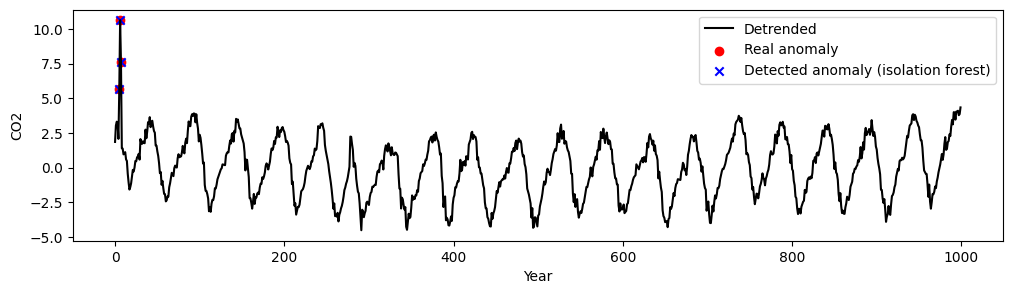

In [15]:
plt.figure(figsize=(12,3))
plt.plot(contam_detrended, color="k", linestyle="-", label="Detrended")
plt.scatter(anomaly_idx, contam_detrended[anomaly_idx], c="r", label="Real anomaly")
plt.scatter(iso_forest_anomaly_idx, contam_detrended[iso_forest_anomaly_idx], marker="x",
            c="b", label="Detected anomaly (isolation forest)")
plt.xlabel("Year")
plt.ylabel("CO2")
plt.legend()
# plt.savefig("../figures/airpassengers_iso_forest.png", dpi=200)
plt.show()

#### [Auto-encoder reconstruction](https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb)

In [17]:
detrended = signal.detrend(airpassengers.flatten()).reshape(-1,1)
contam_detrended = signal.detrend(contam_airpassengers.flatten()).reshape(-1,1)

In [18]:
train_size = int(len(airpassengers) * 0.9)
test_size = len(airpassengers) - train_size
train, val = detrended[:train_size], detrended[train_size:]

In [21]:
lookback = 10
_, y_train = create_dataset(train, lookback=lookback)
_, y_val = create_dataset(val, lookback=lookback)
_, y_normal = create_dataset(detrended, lookback=lookback)
_, y_anomaly = create_dataset(contam_detrended, lookback=lookback)
print(y_train.shape)
print(y_val.shape)
print(y_normal.shape)
print(y_anomaly.shape)

torch.Size([890, 10, 1])
torch.Size([90, 10, 1])
torch.Size([990, 10, 1])
torch.Size([990, 10, 1])


In [23]:
train_dataset, seq_len, n_features = create_auto_encoder_dataset(y_train)
val_dataset, _, _ = create_auto_encoder_dataset(y_val)
normal_dataset, _, _ = create_auto_encoder_dataset(y_normal)
anomaly_dataset, _, _ = create_auto_encoder_dataset(y_anomaly)

In [28]:
model = RecurrentAutoencoder(seq_len, n_features, 50)
model = model.to(DEVICE)

model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=50
)

Epoch 1: train loss 11.802455071652874 val loss 9.790725693437789
Epoch 2: train loss 10.054695311690985 val loss 8.859382899602254
Epoch 3: train loss 8.670472116282816 val loss 7.762558484077454
Epoch 4: train loss 7.985396713353275 val loss 7.549319458007813
Epoch 5: train loss 7.8256275565436715 val loss 7.463810388247172
Epoch 6: train loss 7.6347262107924125 val loss 7.192254442638821
Epoch 7: train loss 7.5957175545478135 val loss 9.610494486490886
Epoch 8: train loss 7.239233174216881 val loss 7.541056227684021
Epoch 9: train loss 7.413088842590203 val loss 7.370462332831488
Epoch 10: train loss 7.186636037371132 val loss 7.618766850895351
Epoch 11: train loss 7.101706289843227 val loss 7.938445811801486
Epoch 12: train loss 7.2806971681251955 val loss 7.062261070145501
Epoch 13: train loss 7.066187882423401 val loss 6.8730485227372915
Epoch 14: train loss 7.120606307903032 val loss 7.2541265434688995
Epoch 15: train loss 7.027279009577933 val loss 6.870332781473795
Epoch 16: t

In [29]:
predictions, pred_losses = predict(model, anomaly_dataset)

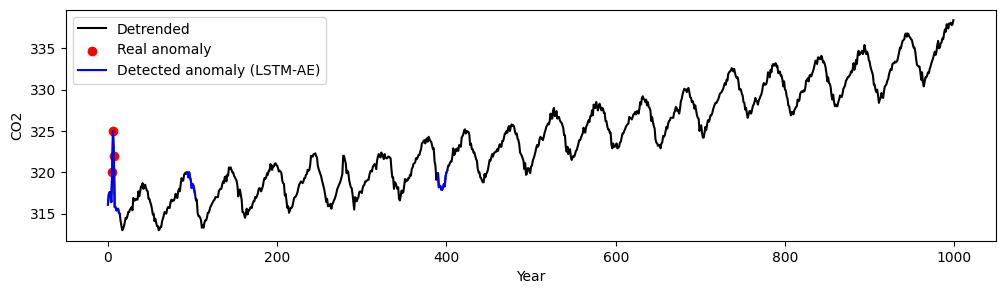

In [30]:
plt.figure(figsize=(12,3))
plt.plot(contam_airpassengers, color="k", linestyle="-", label="Detrended")
plt.scatter(anomaly_idx, contam_airpassengers[anomaly_idx], c="r", label="Real anomaly")

anomaly_intervals = np.ones_like(contam_airpassengers) * np.nan
for _, point_idx in enumerate(np.argsort(np.array(pred_losses))[-10:]):
    interval_idxs = (point_idx * np.ones(lookback) + np.arange(lookback)).astype(int)
    anomaly_intervals[interval_idxs] = contam_airpassengers[interval_idxs]
plt.plot(anomaly_intervals, color='blue', label='Detected anomaly (LSTM-AE)')

plt.xlabel("Year")
plt.ylabel("CO2")
plt.legend()
# plt.savefig("../figures/airpassengers_lstm_ae.png", dpi=200)
plt.show()